In [22]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models


In [23]:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device

device(type='cuda', index=0)

In [24]:
## ResidualBlock残差块的网络结构
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        ## channels:b表示要输入的feature map 数量
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1)
        )

    def forward(self, x):
        return F.relu(self.conv(x) + x)


In [25]:
## 定义图像转换网络
class ImfwNet(nn.Module):
    def __init__(self):
        super(ImfwNet, self).__init__()
        self.downsample = nn.Sequential(
            nn.ReflectionPad2d(padding=4),##使用边界反射填充
            nn.Conv2d(3,32,kernel_size=9,stride=1),
            nn.InstanceNorm2d(32,affine=True),## 在像素值上做归一化
            nn.ReLU(),  ## 3*256*256->32*256*256
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),  ## 32*256*256 -> 64*128*128
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(64,128,kernel_size=3,stride=2),
            nn.InstanceNorm2d(128,affine=True),
            nn.ReLU(),  ## 64*128*128 -> 128*64*64
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
        )
        self.unsample = nn.Sequential(
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),  ## 128*64*64->64*128*128
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),  ## 64*128*128->32*256*256
            nn.ConvTranspose2d(32,3,kernel_size=9,stride=1,padding=4),## 32*256*256->3*256*256; 
        )
    def forward(self,x):
        x = self.downsample(x) ## 输入像素值－2.1～2.7之间
        x = self.res_blocks(x)
        x = self.unsample(x) ## 输出像素值－2.1～2.7之间
        return x

In [26]:
fwnet = torch.load("imfwnet.pkl")
fwnet

ImfwNet(
  (downsample): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): ReLU()
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResidualBlock(
      (conv): Sequential(
        (0)

In [27]:
## 数据准备
## 定义图像的操作过程
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),# 每张图像的尺寸为256*256
    transforms.ToTensor(), ## 像素值转化到0～1
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
    ## 像素值转化到－2.1～2.7
])
## 从文件夹中读取数据
dataset = ImageFolder("drive/MyDrive/COCO", transform=data_transform)
# 每个batch使用4张图像
data_loader = Data.DataLoader(dataset, batch_size=4, shuffle=True,
                              num_workers=2,pin_memory=True)
dataset

Dataset ImageFolder
    Number of datapoints: 39856
    Root location: drive/MyDrive/COCO
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [31]:
## 定义一个读取风格图像或内容图像的函数，并且将图像进行必要转化
def load_image(img_path,shape=None):
    image = Image.open(img_path)
    size = image.size
    ## 如果指定了图像的尺寸，就将图像转化为shape指定的尺寸
    if shape is not None:
        size = shape
    ## 使用transforms将图像转化为张量，并进行标准化
    in_transform = transforms.Compose(
        [transforms.Resize(size), # 图像尺寸变换
         transforms.ToTensor(), # 数组转化为张量
         ## 图像进行标准化
         transforms.Normalize((0.485, 0.456, 0.406), 
                              (0.229, 0.224, 0.225))])
    # 使用图像的RGB通道，并且添加batch纬度
    image = in_transform(image)[:3,:,:].unsqueeze(dim=0)   
    return image

# 定义一个将标准化后的图像转化为便于利用matplotlib可视化的函数
def im_convert(tensor):
    """ 
    将[1, c, h, w]纬度的张量转化为[ h, w,c]的数组
    因为张量进行了表转化，所以要进行标准化逆变换
    """
    tensor = tensor.cpu() ## 数据转换为CPU
    image = tensor.data.numpy().squeeze() # 去处batch纬度数据
    image = image.transpose(1,2,0) ## 置换数组的纬度[c,h,w]->[h,w,c]
    ## 进行标准化的逆操作
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) ##  将图像的取值剪切到0～1之间
    return image

In [36]:
fwnet.eval()
##  从数据中获取一个batch的图片
for step,batch in enumerate(data_loader):
    content_images = batch[0].to(device)
    if step > 0:
        break
    print(content_images.shape)

torch.Size([4, 3, 256, 256])


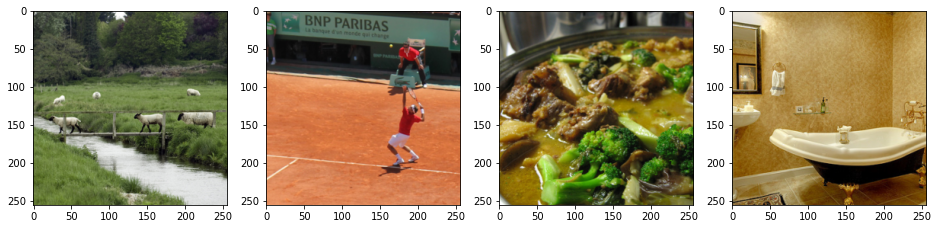

In [37]:
plt.figure(figsize=(16,4))
for ii in range(4):
    im = content_images[ii,...]
    plt.subplot(1,4,ii+1)
    plt.imshow(im_convert(im))
plt.show()

style shape: torch.Size([1, 3, 256, 256])


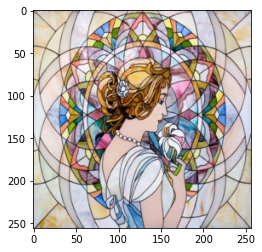

In [35]:
# 读取风格图像
style = load_image("mosaic.jpg",shape = (256,256)).to(device)
print("style shape:",style.shape)
## 可视化图像
plt.figure()
plt.imshow(im_convert(style))
plt.show()

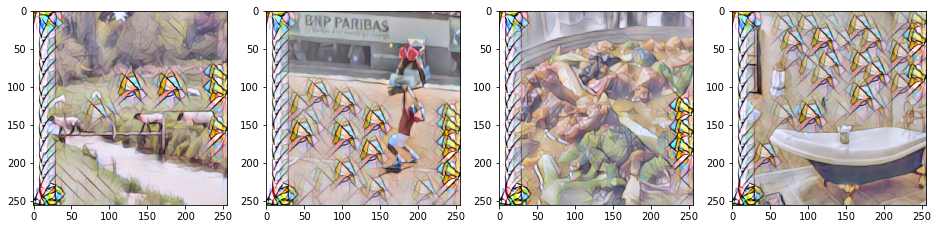

In [38]:
transformed_images = fwnet(content_images)
transformed_images = transformed_images.clamp(-2.1, 2.7)
plt.figure(figsize=(16,4))
for ii in range(4):
    im = im_convert(transformed_images[ii,...])
    plt.subplot(1,4,ii+1)
    plt.imshow(im)
plt.show()